## Pre processing of midi data

In [1]:
# from music21 import midi
# mf = midi.MidiFile()
# mf.open(midis[0]) 
# mf.read()
# mf.close()
# s = midi.translate.midiFileToStream(mf)
# s.show('midi')

In [2]:
from music21 import converter, instrument, note, chord
import json
import sys
import numpy as np
from imageio import imwrite
from PIL import Image

def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element.notes:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}

def midi2image(midi_path,image_path):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = get_notes(notes_to_parse)
                i+=1
            else:
                data[instrument_i.partName] = get_notes(notes_to_parse)

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0".format(i)] = get_notes(notes_to_parse)

    resolution = 0.25

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems
        upperBoundNote = 127
        lowerBoundNote = 21
        maxSongLength = 100

        index = 0
        prev_index = 0
        repetitions = 0
        while repetitions < 1:
            if prev_index >= len(values["pitch"]):
                break

            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))

            pitchs = values["pitch"]
            durs = values["dur"]
            starts = values["start"]

            for i in range(prev_index,len(pitchs)):
                pitch = pitchs[i]

                dur = int(durs[i]/resolution)
                start = int(starts[i]/resolution)

                if dur+start - index*maxSongLength < maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255
                else:
                    prev_index = i
                    break
            img_path = image_path + "/" + midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png")
            imwrite(img_path,matrix)
            index += 1
            repetitions+=1
            


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [ ]:
import os
import numpy as np
from PIL import Image
#import py_midicsv as pm
path = './Jazz_Midi'
#os.chdir(path)
midiz = !ls ./Jazz_Midi
midis = []
for midi in midiz:
    midis.append(path+'/'+midi)
    
new_dir = './image_data'
count = 0
for midi_path in midis:
    try:
        midi2image(midi_path,new_dir)
        count += 1
        print(count)
    except:
        pass

1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26
27


28


29


30


31


32
33


34


35


36


37


38


39


40


41


42
43


44


45


46


47


48


49


50


51


52


53


54


55


56


57
58


59


60


61


62


63


64


65
66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83
84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


In [ ]:
midiz

In [1]:
import os
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np
path = './image_data/'
os.getcwd()
img_list = os.listdir(path)


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
pixels = []
for i in range(len(img_list)):
    if "png" in img_list[i]:
        img = Image.open(path+'/'+img_list[i],'r')
        img = img.resize((106,106), Image.ANTIALIAS)
        pix = np.array(img.getdata())
        if np.mean(img) != 0:    
            pix = pix.astype('float32')
            pix /= 255.0
            pixels.append(pix.reshape(106,106,1))
pixels = np.array(pixels)

In [3]:
with open("numpy_data.npy","wb") as f:
    np.save(f,pixels)

In [4]:
with open("numpy_data.npy","rb") as f:
    a = np.load(f)

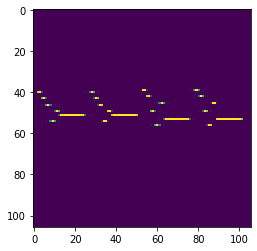

In [9]:
plt.imshow(a[0].reshape([106,106]))

In [1]:
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
        try:
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=image_path.split("/")[-1].replace(".png",".mid"))

import sys
image_path = './GeneratedJazz0.png'
image2midi(image_path)

ValueError: cannot reshape array of size 497664 into shape (288,432,3)

In [5]:
with Image.open(image_path) as image:
    im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)

In [12]:
im_arr.shape[0]/128/128

30.375